In [13]:
# imports 
import kagglehub
import pandas as pd 
import numpy as np
import os 
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# setting constant values!
img_height = 180
img_width = 180
batch_size = 32

# ensure reproducibility
keras.utils.set_random_seed(101)


In [3]:
# imports 
import kagglehub
import pandas as pd 
import numpy as np
import os 

# define and collect image paths and labels

# kaggle import 
path = kagglehub.dataset_download("syedalinaqvi/augmented-skin-conditions-image-dataset")
image_folder = os.path.join(path, "Skin_Conditions")
print("Image folder:", image_folder)
print("Subfolders (classes):", os.listdir(image_folder))

# create empty lists to hold image paths and labels
image_paths = []
labels = []

# iterate through each subfolder and collect image paths and labels
for label in sorted(os.listdir(image_folder)):
    label_folder = os.path.join(image_folder, label)

    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(label_folder, filename))
                labels.append(label)


Image folder: /Users/Diane/.cache/kagglehub/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset/versions/1/Skin_Conditions
Subfolders (classes): ['Carcinoma', 'Keratosis', 'Acne', 'Eczema', 'Rosacea', 'Milia']


In [4]:
# create dataframe
df = pd.DataFrame({"image_path": image_paths, "labels": labels})
# remove rows w/ missing or invalid paths 
df = df[df["image_path"].apply(os.path.exists)]
df = df.drop_duplicates()

# # summary (to check if it matches up w/ what kaggle says)
# print(f"\nTotal images: {len(df)}")
# print("Images per class:")
# print(df["labels"].value_counts())

In [5]:
# train model 

train_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="training",
  seed=101, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 2394 files belonging to 6 classes.
Using 1916 files for training.


In [6]:
# validate model

val_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="validation",
  seed=101,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2394 files belonging to 6 classes.
Using 478 files for validation.


In [7]:
# use autotune to improve performance! 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# data augmentation to generate additional samples for training 
# reduce overfitting 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3),
                      seed = 101),
    layers.RandomRotation(0.1, seed = 101),
    layers.RandomZoom(0.1, seed = 101)
  ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
from tensorflow.keras.layers import BatchNormalization
# batchnormalization to normalize inputs for each layer -> make it more stable

num_classes = 6

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


model.compile(
  optimizer= Adam(3e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 836ms/step - accuracy: 0.4170 - loss: 1.6779 - val_accuracy: 0.1611 - val_loss: 2.0079
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.5762 - loss: 1.1636 - val_accuracy: 0.1674 - val_loss: 2.4500
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 701ms/step - accuracy: 0.6153 - loss: 1.0415 - val_accuracy: 0.1674 - val_loss: 2.9316
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 643ms/step - accuracy: 0.6545 - loss: 0.9310 - val_accuracy: 0.1778 - val_loss: 2.6547
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 612ms/step - accuracy: 0.6994 - loss: 0.8210 - val_accuracy: 0.2301 - val_loss: 2.5454
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 535ms/step - accuracy: 0.7119 - loss: 0.7771 - val_accuracy: 0.3849 - val_loss: 1.8001
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 539ms/step - accuracy: 0.7427 - loss: 0.7209 - val_accuracy: 0.4791 - val_loss: 1.4057
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 531ms/step - accuracy: 0.7641 - loss: 0.6532 - val_accu

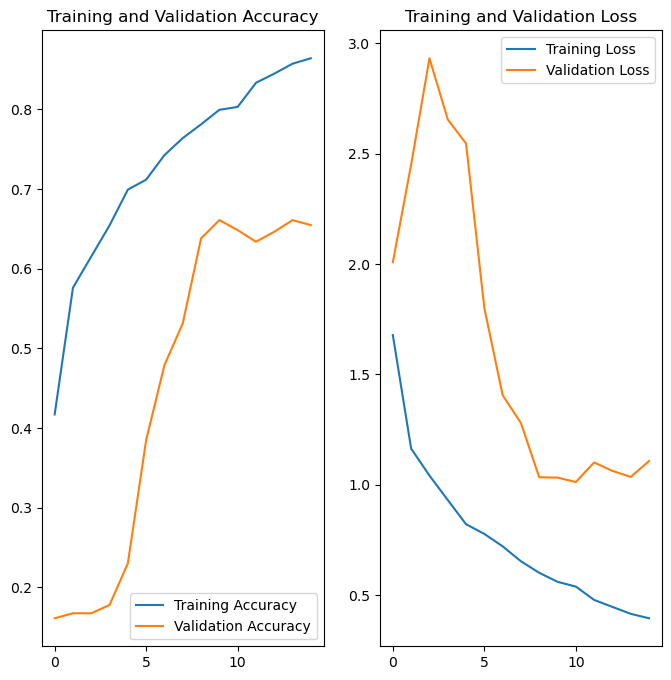

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6548 - loss: 1.1074
Final Validation Loss: 1.1074
Final Validation Accuracy: 0.6548


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# labeling and predictions
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_logits = np.concatenate([model(x, training=False).numpy() for x, y in val_ds], axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# classification report
print(classification_report(y_true, y_pred, target_names = class_names))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

2025-11-17 11:41:08.641901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

        Acne       0.71      0.57      0.63        74
   Carcinoma       0.74      0.75      0.75        84
      Eczema       0.79      0.46      0.58        80
   Keratosis       0.45      0.91      0.60        66
       Milia       0.70      0.59      0.64        87
     Rosacea       0.74      0.69      0.71        87

    accuracy                           0.65       478
   macro avg       0.69      0.66      0.65       478
weighted avg       0.70      0.65      0.66       478

Confusion Matrix:
 [[42  7  2  8  4 11]
 [ 0 63  0 17  4  0]
 [11  3 37 13  9  7]
 [ 0  3  2 60  0  1]
 [ 0  5  4 25 51  2]
 [ 6  4  2 10  5 60]]


2025-11-17 11:41:10.643431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


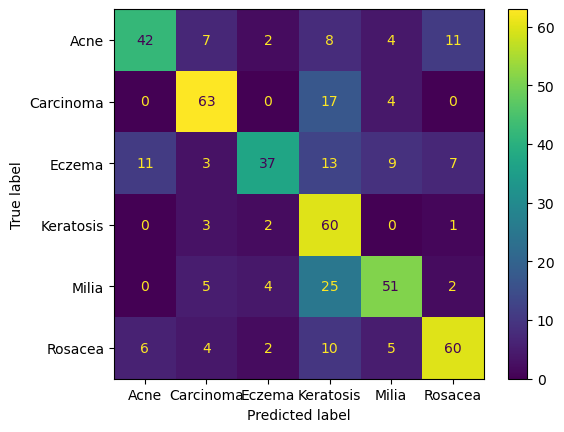

In [14]:
# confusion matrix visualization!

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm , display_labels=df["labels"].unique())
disp.plot()
plt.show()
# print("Confusion Matrix:\n", cm)